# 1. Import Libraries

* Import the required libraries.

In [3]:
pip install Unidecode

     |████████████████████████████████| 235 kB 13.8 MB/s 


In [4]:
import re
import os
import math
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from zipfile import ZipFile
from tqdm.notebook import tqdm
from custom_utility import performance_metrics, preprocess_text, tokenize, predict
from tensorflow.keras import Model, backend, preprocessing
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, Bidirectional, LSTM, GRU, GlobalMaxPool1D, \
                                    GlobalAveragePooling1D, Add, Concatenate, Dense, Activation, TimeDistributed, \
                                    Attention, Dropout, BatchNormalization, Layer, Softmax

In [5]:
from google.colab import drive

In [6]:
pd.options.display.max_columns = None # To display all the columns of a Dataframe.
warnings.filterwarnings('ignore') # Ignore any warnings and do not show them in the cell output.

In [7]:
# Mount GDrive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


----

# 2. Get the data required for Model Training and Evaluation

* Fetch the data in the format required for modelling by using the pickle file saved during the baseline modeling.

In [22]:
%%time
# Read the required data from the pickle file.
#variablesPicklePath = 'Resources/finalVariables.pkl' # Variable containing the path of the pickle file.
variablesPicklePath = F'/content/gdrive/My Drive/Case Study 2/finalVariables.pkl' # Google Drive location    
with open(variablesPicklePath, 'rb') as f:
        
    # Read all the processed variables.
    xTrainText, xTrainNum, yTrainW, yTrainAux, xCVText, xCVNum, yCVW, yCVAux, xTestText, xTestNum, yTestW, yTestAux, testData, embeddingMatrix, lossWeight, vocabSize, maxSeqLength, gloveVectorDim, identitySubgroups, auxColumns = pickle.load(f)

CPU times: user 874 ms, sys: 3.41 s, total: 4.28 s
Wall time: 4.85 s


In [23]:
yTrainTarget = tf.expand_dims(yTrainW[:, 0], axis=1) # Train Class Labels of Toxicity without datapoint weights.
yCVTarget = tf.expand_dims(yCVW[:, 0], axis=1) # Validation Class Labels of Toxicity without datapoint weights
yTestTarget = tf.expand_dims(yTestW[:, 0], axis=1) # Test Class Labels of Toxicity without datapoint weights

print('Train Data: Text Embedded Features Shape: ', xTrainText.shape)
print('Train Data: Numerical Feature(s) Shape: ', xTrainNum.shape)
print('Train Data: Class Label (with weights) Shape: ', yTrainW.shape)
print('Train Data: Toxicity Class Label Shape: ', yTrainTarget.shape)
print('Train Data: Toxicity Subgroup Class Shape: ', yTrainAux.shape)
print('--'*15)
print('Validation Data: Text Embedded Features Shape: ', xCVText.shape)
print('Validation Data: Numerical Feature(s) Shape: ', xCVNum.shape)
print('Validation Data: Class Label (with weights) Shape: ', yCVW.shape)
print('Validation Data: Toxicity Class Label Shape: ', yCVTarget.shape)
print('Validation Data: Toxicity Subgroup Class Shape: ', yCVAux.shape)
print('--'*15)
print('Test Data: Text Embedded Features Shape: ', xTestText.shape)
print('Test Data: Numerical Feature(s) Shape: ', xTestNum.shape)
print('Test Data: Class Label (with weights) Shape: ', yTestW.shape)
print('Test Data: Toxicity Class Label Shape: ', yTestTarget.shape)
print('Test Data: Toxicity Subgroup Class Shape: ', yTestAux.shape)

Train Data: Text Embedded Features Shape:  (1304020, 210)
Train Data: Numerical Feature(s) Shape:  (1304020, 1)
Train Data: Class Label (with weights) Shape:  (1304020, 2)
Train Data: Toxicity Class Label Shape:  (1304020, 1)
Train Data: Toxicity Subgroup Class Shape:  (1304020, 6)
------------------------------
Validation Data: Text Embedded Features Shape:  (270732, 210)
Validation Data: Numerical Feature(s) Shape:  (270732, 1)
Validation Data: Class Label (with weights) Shape:  (270732, 2)
Validation Data: Toxicity Class Label Shape:  (270732, 1)
Validation Data: Toxicity Subgroup Class Shape:  (270732, 6)
------------------------------
Test Data: Text Embedded Features Shape:  (230122, 210)
Test Data: Numerical Feature(s) Shape:  (230122, 1)
Test Data: Class Label (with weights) Shape:  (230122, 2)
Test Data: Toxicity Class Label Shape:  (230122, 1)
Test Data: Toxicity Subgroup Class Shape:  (230122, 6)


----

# 3. Custom Loss Function

* Let's define a custom Loss Function to calculate the loss for the Class Label having toxicity and weights.

In [24]:
# Reference: https://github.com/nidhibansal1902/Jigsaw-Unintended-Bias-in-Toxicity-Classification/blob/master/Jigsaw-LSTM%20with%20Glove%20Embedding%20New.ipynb
def customLoss(yActual, yPred):
    '''
    Function to calculate loss for the toxic class label.
    
    Parameters:
    -----------
    yActual: array-like
        Actual Class Labels.
    yPred: array-like
        Predicted Class Labels.
    '''
    
    return binary_crossentropy(backend.reshape(yActual[:, 0], (-1, 1)), yPred) * yActual[:, 1]

----

# 4. Callbacks

* Here, we will define a function to return the required callbacks which can used while training a model.

In [25]:
def getCallbacks(fileLocation, modelCheckpoint=True, earlyStopping=True, reduceLROnPlateau=False, lrScheduler=True,
                 dictMonitor={}, dictMode={}, dictPatience={}):
    '''
    Function to return some callbacks which will be used while training a model.
    
    Parameters:
    ----------
    fileLocation: str
        File path to store the best model.
    modelCheckpoint: bool
        Flag if true, returns ModelCheckpoint callback.
    earlyStopping: bool
        Flag is true, returns EarlyStopping callback.
    reduceLROnPlateau: bool
        Flag if true, returns ReduceLROnPlateau callback.
    lrScheduler: bool
        Flag if true, returns LearningRateScheduler callback.
    dictMonitor: dictionary
        Dictionary containing the Callback names as keys and the metric to be monitored as their values.
    dictMode: dictionary
        Dictionary containing the Callback names as keys and the modes of the metrics as their values.
    dictPatience: dictionary
        Dictionary containing the Callback names as keys and the patience of the callback as their values.
    '''
    
    resultCallbacks = list() # List to store the applicable callbacks to be returned.
    
    # If Model Checkpoint Callback is required.
    if modelCheckpoint == True:
        
        # Callback to save the best model
        modelCheckpointCB = ModelCheckpoint(filepath=fileLocation, save_best_only=True)
        
        # Add the callback to the result list.
        resultCallbacks.append(modelCheckpointCB)
        
    # If the Early Stopping Callback is required.
    if earlyStopping == True and dictMonitor.get('earlyStopping') != None and dictMode.get('earlyStopping') != None and dictPatience.get('earlyStopping') != None:
        
        # Callback to do early stop
        earlyStoppingCB = EarlyStopping(monitor=dictMonitor.get('earlyStopping'),
                                                mode=dictMode.get('earlyStopping'),
                                                patience=dictPatience.get('earlyStopping'))
        
        # Add the callback to the result list.
        resultCallbacks.append(earlyStoppingCB)
        
        
    # If the Reduce Learning Rate Plateau Callback is required.
    if reduceLROnPlateau == True and dictMonitor.get('reduceLROnPlateau') != None and dictMode.get('reduceLROnPlateau') != None and dictPatience.get('reduceLROnPlateau') != None:
        
        # Callback to decay the Learning Rate        
        reduceLROnPlateauCB = ReduceLROnPlateau(monitor=dictMonitor.get('reduceLROnPlateau'), factor=0.1, 
                                                        patience=dictPatience.get('reduceLROnPlateau'), verbose=1,
                                                        mode=dictMode.get('reduceLROnPlateau'))
        
        # Add the callback to the result list.
        resultCallbacks.append(reduceLROnPlateauCB)
        
    # If the Learning Rate Scheduler Callback is required.
    if lrScheduler == True:
        
        # Callback for learning rate scheduler
        lrSchedulerCB = LearningRateScheduler(lambda epoch: 1e-3 * (0.6  ** 1))
        
        # Add the callback to the result list.
        resultCallbacks.append(lrSchedulerCB)
        
    # Return the list of required callbacks.
    return resultCallbacks

----

# 5. Function to Plot the Model Performance over epochs

* We will define some functions that can be used to:<br>
&emsp; i. Plot the model's training and validation losses and accuracies over each epoch.<br>
&emsp; ii. Plot the model's learning rates over each epoch.<br>

In [26]:
# Reference: https://neptune.ai/blog/how-to-choose-a-learning-rate-scheduler
#### Function to plot the learning rate 
def plotLR(history, figsize=(10, 5)):
    '''
    Function to the plot the value of learning rates for the model over each epoch.

    Parameters:
    ---------
    history: keras.callbacks.History
        Model object that holds the history details of the trained model.
    figsize: tuple
        Figure size of the plot.
    '''
    learning_rate = history.history['lr'] # Fetch the Learning Rates.

    epochs = range(1, len(learning_rate) + 1) # Define the epoch values to be shown in the x-axis.

    fig = plt.figure(figsize=figsize) # Create a new figure with the given figure size.
    
    # Plot the Epochs on the x-axis and the learning rates on the y-axis.
    plt.plot(epochs, learning_rate)
    plt.title('Learning Rate Curve', fontsize=20) # Title of the Plot.
    plt.xlabel('Epoch', fontsize=15) # Label on the x-axis.
    plt.ylabel('Learning Rate', fontsize=15) # Label on the y-axis.
    plt.show() # Show the plot.

In [27]:
### Functions to plot the train history 
def plotPerformance(history, figsize=(15, 8), accMetric='accuracy'):
    '''
    Function to plot the training and validation losses and accuracies over each epoch.

    Parameters:
    ----------
    history: keras.callbacks.History
        Model object that holds the history details of the trained model.
    figsize: tuple
        Figure size of the plot.
    '''
    
    fig = plt.figure(figsize=figsize) # Create a new figure with the given figure size.
    
    # Plot the Losses
    fig = plt.subplot(1, 2, 1) # row 1 col 2 index 1. 1st Subplot to display the losses.
    plt.plot(history.history['loss']) # Plot the training data loss.
    plt.plot(history.history['val_loss']) # Plot the validation data loss.
    plt.legend(['Train Loss', 'Validation Loss']) # Add legend to the plot.
    plt.title(f'Loss Curves', fontsize=20) # Title of the subplot.
    plt.xlabel('Epoch', fontsize=15) # Label to be displayed on the x-axis.
    plt.ylabel('Loss', fontsize=15) # Label to be displayed on the y-axis.
    
    # Plot the Accuracies 
    fig = plt.subplot(1, 2, 2) # row 1 col 2 index 2. 2nd subplot to display the accuracies.
    plt.plot(history.history[accMetric]) # Plot the training data accuracy.
    plt.plot(history.history['val_' + accMetric]) # Plot the validation data accuracy.
    plt.legend(['Train Accuracy', 'Validation Accuracy']) # Add legend to the plot.
    plt.title(f'Accuracy Curves', fontsize=20) # Title of the subplot.
    plt.xlabel('Epoch', fontsize=15) # Label to be displayed on the x-axis.
    plt.ylabel('Accuracy', fontsize=15) # Label to be displayed on the y-axis.
    plt.show() # Show the plot.

----

# 6. Model - Bidirectional LSTM with Attention Mechanism

* Use a Bidirectional LSTM Model with Attention Mechanism

## 6.1. Attention Layer

* Let's define the attention layer using Bahdanu Attention Mechanism.

![image.png](https://matthewmcateer.me/media/attention/additive_attention.png)

In [28]:
class Attention(Layer):
    '''
    Class that calculates the score based on the concat scoring function using Bahdanu Attention Mechanism
    and returns the Content Vector having the context of all the encoder inputs.
    '''
    def __init__(self, attUnits, name=None):
        '''
        Constructor of the class.
        
        Parameter:
        ---------
        attUnits: int
            Number of attention units (or number of units in the LSTM layer).
        name: str
            Name of the Layer.
        '''
        
        # Call the base class constructor.
        super().__init__()
        
        # Initialize the variables
        self.attUnits = attUnits
        #self.name = name
        
        # Dense Layer for Weight Matrix W1
        self.denseC1 = Dense(self.attUnits)
        
        # Dense Layer for Weight Matrix W2
        self.denseC2 = Dense(self.attUnits)
        
        # Dense Layer for the vector v
        self.denseC3 = Dense(1)
        
    def call(self, hiddenState, encoderOutput):
        '''
        Attention mechanism takes two inputs: encoder output and the hidden states.
        Concate scoring function is used here, to find the score or similarity between hidden states and encoder output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector.
        
        Parameters:
        ----------
        hiddenState: Tensor
            Hidden state output from the LSTM Encoder.
        encoderOutput: Tensor
            Encoder Output of the LSTM Encoder.
        '''
        
        # Expand the dimension of the hidden state on the second axis.
        hiddenStateExpanded = tf.expand_dims(hiddenState, axis=1)
        
        # Dot Product of the Hidden State (batch_size x 1 x lstm_units) with the Weight Matrix 1 (lstm_units x att_units).
        dotProduct1 = self.denseC1(hiddenStateExpanded)
        
        # Dot Product of the Encoder State Output (batch_size x sequence_length x lstm_units) and
        # Weight Matrix 2 (lstm_units x att_units).
        dotProduct2 = self.denseC2(encoderOutput)
        
        # Concatenation of the Dot Products.
        concat = dotProduct1 + dotProduct2
        
        # Take the tanh of the concatenated result.
        tanh = tf.math.tanh(concat)
        
        # Dot Product of the tanh and v Vector.
        similarityVector = self.denseC3(tanh)
        
        # Apply Softmax to get the probability scores.
        attentionWeights = Softmax(axis=1)(similarityVector)
        
        # Find the weighted average of all the LSTM Encoder Hidden States (Matrix Multiplication element-wise).
        weights = attentionWeights * encoderOutput
        
        # Add all the weights along the axis having sequence length, to get the weighted average (Context Vector).
        contextVector = tf.reduce_sum(weights, axis=1)
        
        # Return the Context Vector.
        return contextVector

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            "attUnits": self.attUnits,
        })
        return config

## 6.2. Model Architecture

In [29]:
def getModelBiLSTMAttn(seqLen=maxSeqLength, vocabSize=vocabSize, gloveVecDim=gloveVectorDim, weightMatrix=embeddingMatrix,
           isTrainable=False, units=256):
    '''
    Function to generate the Model Architecture using Bidirectional LSTM with Attention Mechanism.
    
    Parameters:
    ----------
    seqLen: int
        Maximum sequence length of the comment texts.
    vocabSize: int
        Vocabulary Size of the comment texts.
    gloveVecDim: int
        Dimension of the words in GloVe.
    weightMatrix: numpy.ndarray
        Embedding Matrix.
    isTrainable: bool
        Flag to decide whether to train the embedding layer.
    units: int
        Number of units required in GRU.
    '''
    
    # Clear the graph of TensorFlow
    backend.clear_session()
    
    # Input Layer for the comment text
    inputLayerText = Input(shape= (seqLen, ), name='InputLayerText')
    
    # Embedding Layer for the Comment Text
    embeddingLayerText = Embedding(input_dim= vocabSize, output_dim=gloveVecDim, weights=[weightMatrix], 
                                          trainable=isTrainable, name='EmbeddingLayerText')(inputLayerText)
    
    # Spatial Droput Layer
    spatialDropout1DLayer1 = SpatialDropout1D(rate=0.2, name='SpatialDropout1DLayer1')(embeddingLayerText)
    
    # Bidirectional LSTM Layer
    biLSTMLayer1 = Bidirectional(LSTM(units, return_sequences=True, name='BiLSTMLayer1'))(spatialDropout1DLayer1)
    
    # Spatial Droput Layer
    spatialDropout1DLayer2 = SpatialDropout1D(rate=0.2, name='SpatialDropout1DLayer2')(biLSTMLayer1)
    
    # Bidirectional GRU Layer
    lstmOutput, frwdHdnState, frwdCellState, backHdnState, backCellState = \
        Bidirectional(LSTM(units, return_sequences=True, return_state=True, name='BiLSTMLayer2'))(spatialDropout1DLayer2)
    
    # Concate Hidden States
    hiddenState = Concatenate(name='ConcatenateStates')([frwdHdnState, backHdnState])
    
    # Attention Layer
    attentionLayer = Attention(attUnits=seqLen, name='AttentionLayer')(hiddenState, lstmOutput)
    
    # Batch Normalization Layer
    batchNormLayer1 = BatchNormalization(name='BatchNormalizationLayer1')(attentionLayer)
    
    # Dropout Layer
    dropoutLayer1 = Dropout(rate=0.5, name='DropoutLayer1')(batchNormLayer1)
    
    # Dense Layer on the output of above concatenate layer
    denseLayer1 = Dense(units, activation='relu', name='DenseLayer1')(dropoutLayer1)
    
    # Batch Normalization Layer
    batchNormLayer2 = BatchNormalization(name='BatchNormalizationLayer2')(denseLayer1)
    
    # Dropout Layer
    dropoutLayer2 = Dropout(rate=0.4, name='DropoutLayer2')(batchNormLayer2)
    
    # Dense Layer on the output of above concatenate layer
    denseLayer2 = Dense(units/2, activation='relu', name='DenseLayer2')(dropoutLayer2)
    
    # Batch Normalization Layer
    batchNormLayer3 = BatchNormalization(name='BatchNormalizationLayer3')(denseLayer2)
    
    # Dropout Layer
    dropoutLayer3 = Dropout(rate=0.3, name='DropoutLayer3')(batchNormLayer3)
    
    # Output Layer for Toxicity
    outputToxicity = Dense(1, activation='sigmoid')(dropoutLayer3)
    
    # Output Layer for the Auxiliary Toxicity Subgroups
    outputAux = Dense(6, activation='sigmoid')(dropoutLayer3)
    
    # Define the Model using the above defined input and output layers
    model = Model(inputs=inputLayerText, outputs= [outputToxicity, outputAux])
    
    # Return the Model
    return model

In [30]:
# Call the function 'getModelBiLSTMAttn()' to get the model architecture.
modelBiLSTMAttn = getModelBiLSTMAttn(isTrainable=False)

# Print the summary of the Model to check if all the layers are properly defined or not.
modelBiLSTMAttn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayerText (InputLayer)    [(None, 210)]        0           []                               
                                                                                                  
 EmbeddingLayerText (Embedding)  (None, 210, 300)    151513200   ['InputLayerText[0][0]']         
                                                                                                  
 SpatialDropout1DLayer1 (Spatia  (None, 210, 300)    0           ['EmbeddingLayerText[0][0]']     
 lDropout1D)                                                                                      
                                                                                                  
 bidirectional (Bidirectional)  (None, 210, 512)     1140736     ['SpatialDropout1DLayer1[0][0

## 6.3. Create and Save the Plot of the Model

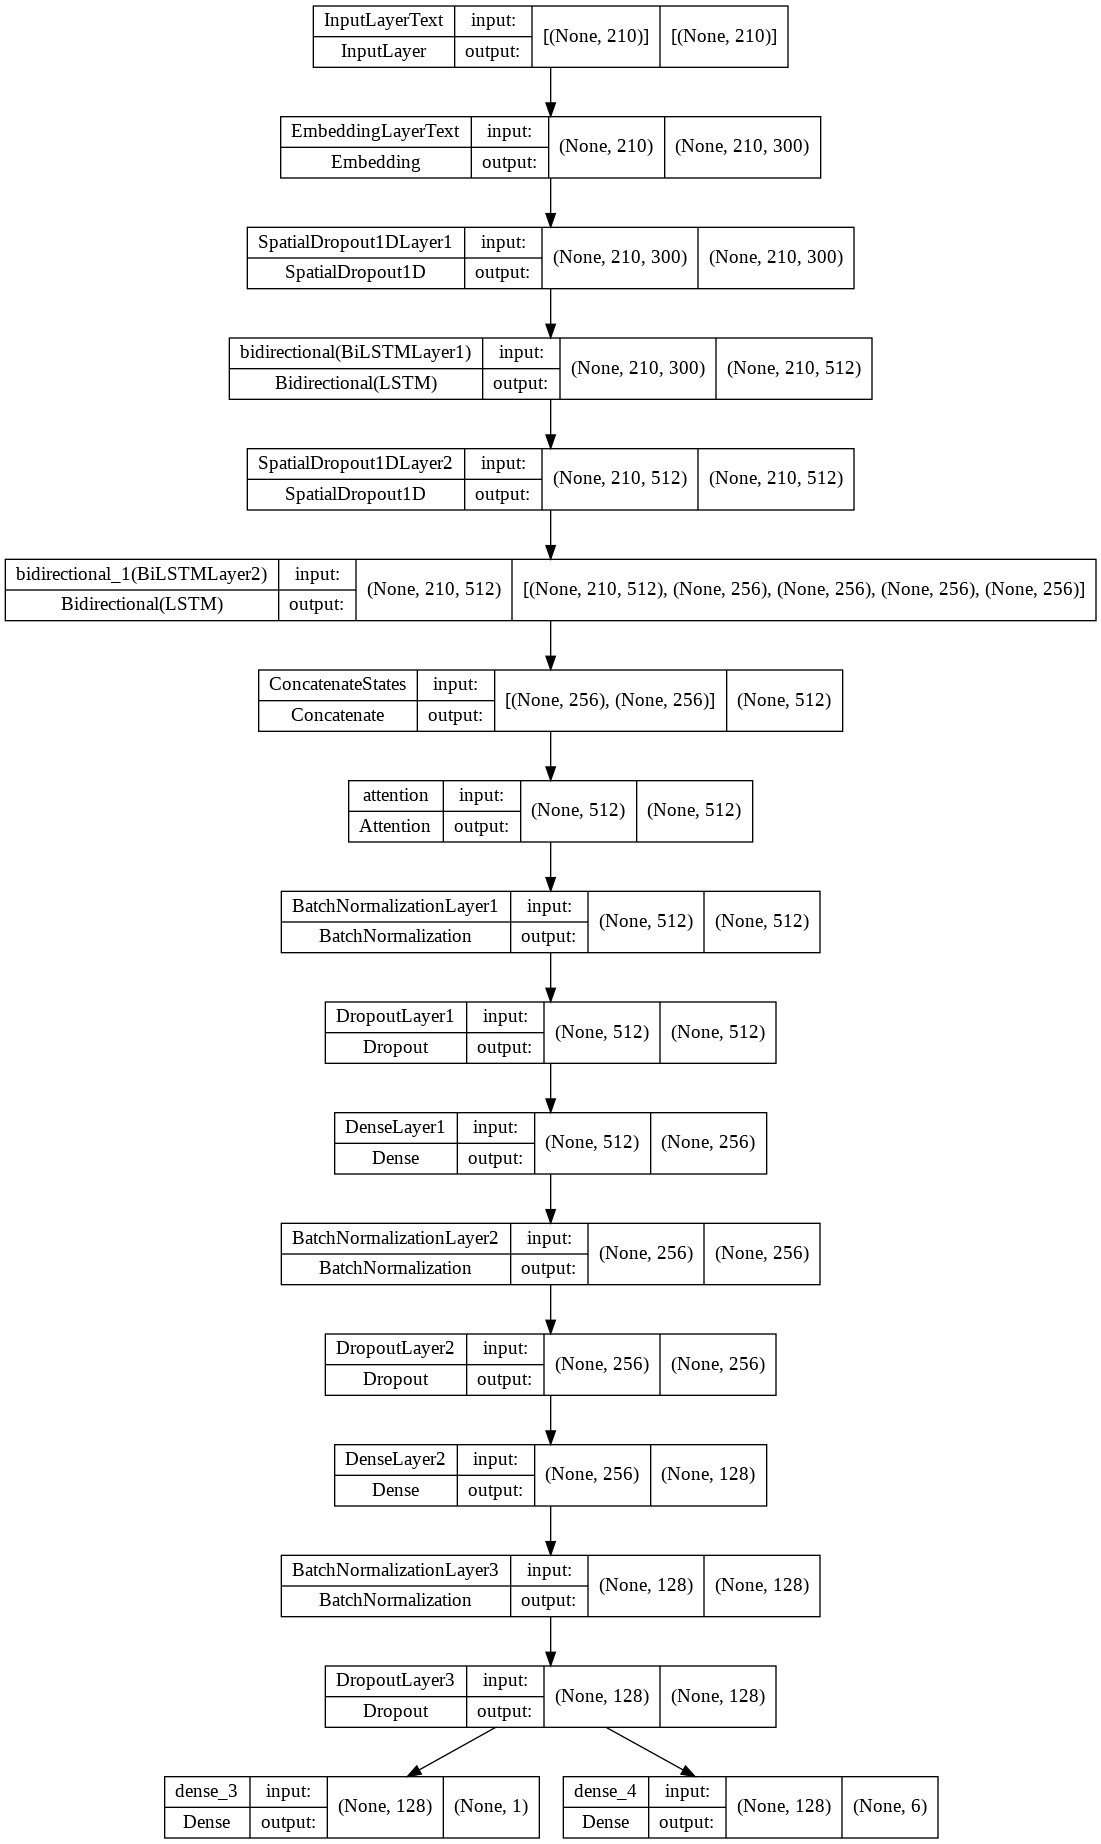

In [31]:
# Create and save the model plot.
plot_model(modelBiLSTMAttn, to_file='Resources/modelBiLSTMAttn.png', show_shapes=True, show_layer_names=True)

## 6.4. Define Callbacks and Compile the Model

In [32]:
# Compile the Model
modelBiLSTMAttn.compile(optimizer= Adam(epsilon= 1e-8), loss= [customLoss, 'binary_crossentropy'], metrics=['accuracy'], 
                        loss_weights=[lossWeight, 1.0])

# Define the dictionaries required for setting up the callback properties.
monitor = {'earlyStopping': 'val_loss', 'reduceLROnPlateau': 'val_loss'}
mode = {'earlyStopping': 'min', 'reduceLROnPlateau': 'min'}
patience = {'earlyStopping': 5, 'reduceLROnPlateau': 2}

# File path to store the best model to.
#filePath = 'BestModels/modelBiLSTMAttn.h5'
filePath = F'/content/gdrive/My Drive/Case Study 2/BestModels/modelBiLSTMAttn.h5'

# Call the function 'getCallbacks()' to get the required callbacks.
modelBiLSTMAttnCallbacks = getCallbacks(fileLocation=filePath, reduceLROnPlateau=False, lrScheduler=True,
                                        dictMonitor=monitor, dictMode=mode, dictPatience=patience)

## 6.5. Train the Model

In [ ]:
historyBiLSTMAttn = modelBiLSTMAttn.fit(x=xTrainText, y=[yTrainW, yTrainAux], batch_size=512, epochs=15, verbose=1, 
                                      validation_data=(xCVText, [yCVW, yCVAux]), callbacks= modelBiLSTMAttnCallbacks)

Epoch 1/15
2547/2547 [==============================] - 1116s 436ms/step - loss: 0.3878 - dense_3_loss: 0.0785 - dense_4_loss: 0.1327 - dense_3_accuracy: 0.4626 - dense_4_accuracy: 0.2080 - val_loss: 0.2653 - val_dense_3_loss: 0.0575 - val_dense_4_loss: 0.0786 - val_dense_3_accuracy: 0.4718 - val_dense_4_accuracy: 0.2043 - lr: 6.0000e-04
Epoch 2/15
2547/2547 [==============================] - 1108s 435ms/step - loss: 0.2726 - dense_3_loss: 0.0593 - dense_4_loss: 0.0800 - dense_3_accuracy: 0.4720 - dense_4_accuracy: 0.2043 - val_loss: 0.2543 - val_dense_3_loss: 0.0544 - val_dense_4_loss: 0.0775 - val_dense_3_accuracy: 0.4726 - val_dense_4_accuracy: 0.2046 - lr: 6.0000e-04
Epoch 3/15
2547/2547 [==============================] - 1107s 435ms/step - loss: 0.2595 - dense_3_loss: 0.0560 - dense_4_loss: 0.0776 - dense_3_accuracy: 0.4731 - dense_4_accuracy: 0.2071 - val_loss: 0.2495 - val_dense_3_loss: 0.0537 - val_dense_4_loss: 0.0751 - val_dense_3_accuracy: 0.4734 - val_dense_4_accuracy: 0.21

In [33]:
# Load the previously trained model to continue for further epochs.
modelBiLSTMAttn.load_weights(F'/content/gdrive/My Drive/Case Study 2/BestModels/modelBiLSTMAttn.h5')

In [34]:
# Train the Model from Epoch 16 onwards.
historyBiLSTMAttn = modelBiLSTMAttn.fit(x=xTrainText, y=[yTrainW, yTrainAux], batch_size=512, initial_epoch=15, epochs=30, verbose=1, 
                                      validation_data=(xCVText, [yCVW, yCVAux]), callbacks= modelBiLSTMAttnCallbacks)

Epoch 16/30
2547/2547 [==============================] - 2053s 804ms/step - loss: 0.2125 - dense_3_loss: 0.0434 - dense_4_loss: 0.0715 - dense_3_accuracy: 0.4774 - dense_4_accuracy: 0.2171 - val_loss: 0.2471 - val_dense_3_loss: 0.0542 - val_dense_4_loss: 0.0709 - val_dense_3_accuracy: 0.4703 - val_dense_4_accuracy: 0.2217 - lr: 6.0000e-04
Epoch 17/30
2547/2547 [==============================] - 2048s 804ms/step - loss: 0.2074 - dense_3_loss: 0.0419 - dense_4_loss: 0.0712 - dense_3_accuracy: 0.4778 - dense_4_accuracy: 0.2177 - val_loss: 0.2498 - val_dense_3_loss: 0.0552 - val_dense_4_loss: 0.0706 - val_dense_3_accuracy: 0.4730 - val_dense_4_accuracy: 0.2218 - lr: 6.0000e-04
Epoch 18/30
2547/2547 [==============================] - 2048s 804ms/step - loss: 0.2030 - dense_3_loss: 0.0406 - dense_4_loss: 0.0710 - dense_3_accuracy: 0.4783 - dense_4_accuracy: 0.2183 - val_loss: 0.2514 - val_dense_3_loss: 0.0557 - val_dense_4_loss: 0.0705 - val_dense_3_accuracy: 0.4732 - val_dense_4_accuracy: 0

## 6.6. Plot the Model Performance

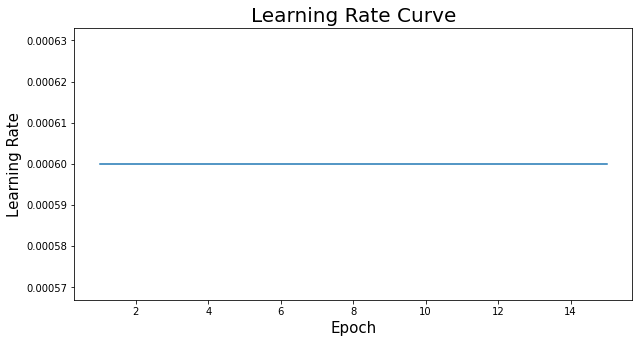

In [ ]:
# Call the 'plotLR()' function to plot the Learning Rate used during training.
plotLR(historyBiLSTMAttn)

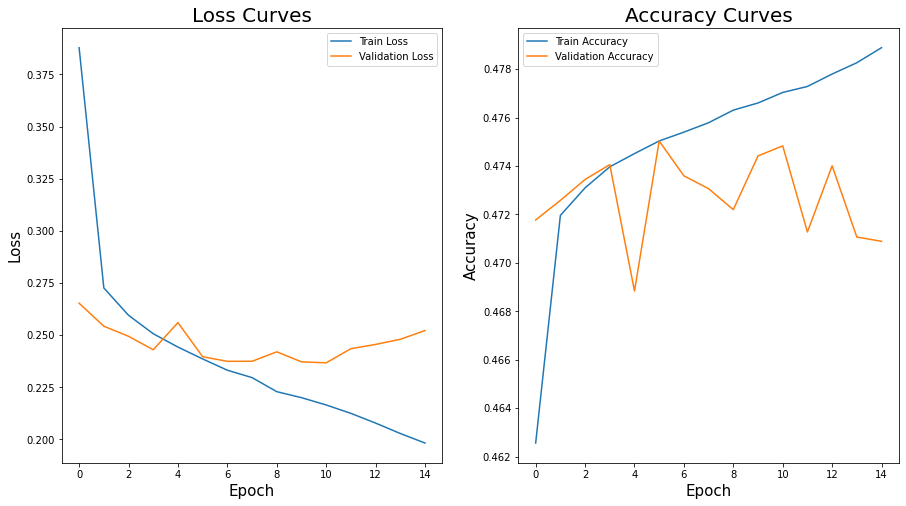

In [ ]:
# Call the function 'plotPerformance()' to plot the loss and accuracy of the Model over each epochs.
plotPerformance(historyBiLSTMAttn, accMetric='dense_3_accuracy')

## 6.7. Evaluation on the Test Dataset of Train_Test Split

In [ ]:
%%time
# Predict the probabilities of the class label of the Test Dataset and store it in a new feature 'yPredProb' of the Test Dataset.
testData['yPredProb'] = modelBiLSTMAttn.predict(xTestText)[0].flatten()

# Call the 'computeBiasMetricsForModel()' function to get the Subgroup, BPSN and BNSP AUCs for each identity sugroups
biasMetrics = performance_metrics.computeBiasMetricsForModel(data=testData, subgroups=identitySubgroups, predClassLabel='yPredProb', actualClassLabel='target')

CPU times: user 2min 2s, sys: 11.5 s, total: 2min 13s
Wall time: 3min 37s


In [ ]:
# Display the Bias Metrics
biasMetrics

,Subgroup,Subgroup Size,Subgroup AUC,BPSN AUC,BNSP AUC
2,homosexual_gay_or_lesbian,1406,0.832142,0.883673,0.941277
7,white,3162,0.841033,0.882053,0.946161
6,black,1863,0.846194,0.870136,0.952823
5,muslim,2569,0.853504,0.906512,0.934514
4,jewish,995,0.884101,0.926748,0.931220
8,psychiatric_or_mental_illness,625,0.906977,0.913741,0.952381
0,male,5769,0.911742,0.934876,0.941417
1,female,6879,0.916375,0.942339,0.937751
3,christian,5128,0.933680,0.957893,0.930990


In [ ]:
# Get the final metric score
finalMetricScore = performance_metrics.computeFinalMetric(biasMetrics, performance_metrics.computeOverallAUC(data=testData, actualClassLabel='target', predClassLabel='yPredProb'))
print('Final Metric Score on the Test Dataset: ', finalMetricScore)

Final Metric Score on the Test Dataset:  0.9205749031209677


## 6.8. Predict the Toxicity of the given Test Dataset

* Now, we will predict the toxicity score for the comment texts given in the Test Dataset of the Problem.

In [ ]:
%%time
# Read the Test Dataset given in the Kaggle Problem
test = pd.read_csv('Data/test.csv')

CPU times: user 360 ms, sys: 25.9 ms, total: 386 ms
Wall time: 407 ms


In [ ]:
# Preprocess the comment text and store the processed text in a new feature 'preprocessed_text'
lstComments = test['comment_text'] # List of all comment texts
lstProcessedComments = list() # List to store the preprocess comment texts

# Preprocess each comment and store in the list 'lstProcessedComments'
for comment in tqdm(lstComments):

    lstProcessedComments.append(preprocess_text.preprocess(comment))
    
# Create a new Feature 'preprocessed_text' for the new preprocessed comments.
test['preprocessed_text'] = lstProcessedComments

  0%|          | 0/97320 [00:00<?, ?it/s]

In [ ]:
%%time
# Tokenize the preprocess comments texts (Post Padding)
# gloveCommentTest = tokenize.gloveEmbedText(texts=test['preprocessed_text'], maxLen = maxSeqLength)

#tokenizerFile = '../Resources/tokenizer.pkl'
tokenizerFile = F'/content/gdrive/My Drive/Case Study 2/tokenizer.pkl'
with open(tokenizerFile, 'rb') as f:
    
    tokenizer = pickle.load(f)

# Do integer encoding of the input text(s).
intEncodedTexts = tokenizer.texts_to_sequences(test['preprocessed_text'])

# Pad the integer encoded comments texts (Post Padding) and return.
gloveCommentTest = preprocessing.sequence.pad_sequences(intEncodedTexts, maxlen=maxSeqLength, padding='post')

CPU times: user 3.47 s, sys: 78.5 ms, total: 3.55 s
Wall time: 3.54 s


In [ ]:
%%time
# Predict the probabilities of the class label of the Test Dataset and store it in a new feature 'yPredProb' of the Test Dataset.
test['prediction'] = modelBiLSTMAttn.predict(gloveCommentTest)[0].flatten()

CPU times: user 50.7 s, sys: 4.77 s, total: 55.5 s
Wall time: 1min 30s


In [ ]:
# Save the result in the required format for submission
submission = test[['id', 'prediction']]

In [ ]:
submission.to_csv(F'/content/gdrive/My Drive/Case Study 2/submission_bilstmAttn.csv', index=False)

In [ ]:
submission.to_csv('submission_bilstmAttn.csv', index=False)

----

## 6.9. Kaggle Score

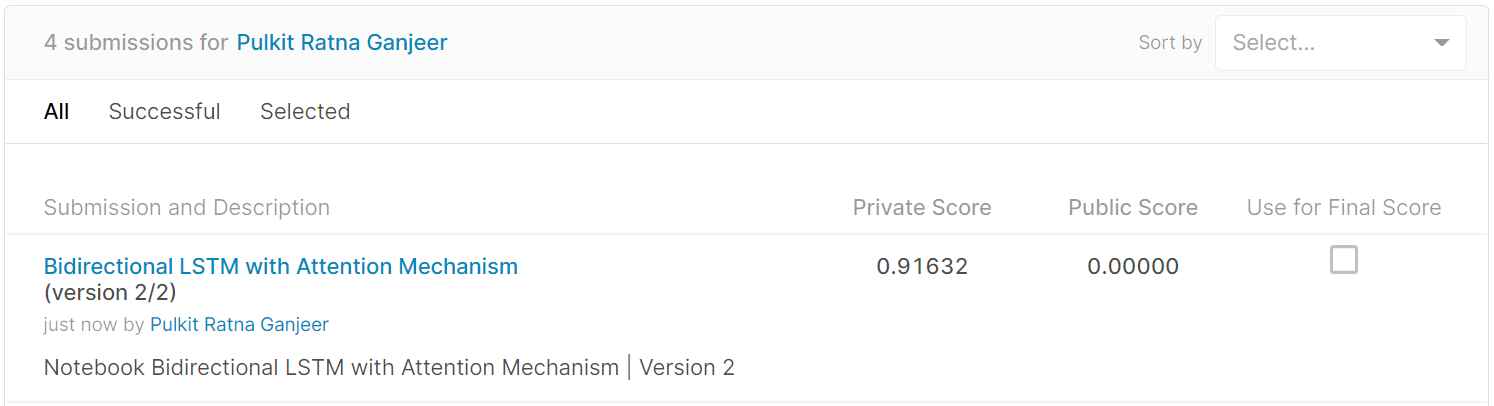

----